In [2]:
%matplotlib inline

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
import os
import sys
import random
PATH = '/home/ubuntu/music-generation/'
sys.path.append(os.path.join(PATH, 'midi'))

In [35]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

In [36]:
import pretty_midi
from midi_utils import midiread, midiwrite
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [7]:
midi_data = midiread('data/MuseData/train/bach.cant.0001_midip_01.mid')

In [8]:
midi_data.piano_roll.shape[0]

2661

### DataLoader

In [9]:
import numpy as np
import torch
import torch.utils.data as data


def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.T
    
    # Binarize the pressed notes 
    piano_roll[piano_roll > 0] = 1  # no need as unique values are 0 and 1
    
    return piano_roll

In [12]:
def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
    """
    padding 0 at the end of sequence
    
    """
    # We hardcode 88 -- because we will always use only
    # 88 pitches
    
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, :original_piano_roll_length] = piano_roll

    return padded_piano_roll

In [13]:
class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=None):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = map(lambda filename: os.path.join(midi_folder_path, filename),
                                  midi_filenames)
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
        """Recomputes the longest sequence constant of the dataset.

        Reads all the midi files from the midi folder and finds the max
        length.
        """
        
        sequences_lengths = map(lambda filename: midi_filename_to_piano_roll(filename).shape[1],
                                self.midi_full_filenames)
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # -1 because we will shift it
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifted by one time step. from previous step, predict the next one
        input_sequence = piano_roll[:, :-1] # skip take the last one
        ground_truth_sequence = piano_roll[:, 1:] # skip the first one
                
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,
                                                      max_length=self.longest_sequence_length,
                                                      pad_value=-100)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),
                torch.LongTensor(ground_truth_sequence_padded),
                torch.LongTensor([sequence_length]) )

In [14]:
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1) 
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [15]:
trainset = NotesGenerationDataset(os.path.join(PATH, 'data/MuseData/train/'), longest_sequence_length=None)

trainset_loader = data.DataLoader(trainset, batch_size=120,
                                              shuffle=True, num_workers=4, drop_last=True)

In [16]:
X = next(iter(trainset_loader))

In [17]:
input_sequences = X[0]

In [18]:
X[0].shape

torch.Size([120, 2434, 88])

In [19]:
X[1].shape

torch.Size([120, 2434, 88])

In [20]:
X[0][:3]


( 0  ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 1  ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 2  ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.FloatTensor of size 3x2434x88]

In [21]:
X[1][:3]


( 0  ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
 -100 -100 -100  ...  -100 -100 -100
 -100 -100 -100  ...  -100 -100 -100
 -100 -100 -100  ...  -100 -100 -100

( 1  ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
 -100 -100 -100  ...  -100 -100 -100
 -100 -100 -100  ...  -100 -100 -100
 -100 -100 -100  ...  -100 -100 -100

( 2  ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
 -100 -100 -100  ...  -100 -100 -100
 -100 -100 -100  ...  -100 -100 -100
 -100 -100 -100  ...  -100 -100 -100
[torch.LongTensor of size 3x2434x88]

In [22]:
X[2][:5] # sequence length


 151
 703
 119
 329
 164
[torch.LongTensor of size 5x1]

In [23]:
torch.sum(X[0])

206176.0

In [24]:
valset = NotesGenerationDataset(os.path.join(PATH, 'data/MuseData/valid/'), longest_sequence_length=None)

valset_loader = data.DataLoader(valset, batch_size=30, shuffle=False, num_workers=4, drop_last=False)

In [25]:
X_val = next(iter(valset_loader))

In [26]:
X_val[0].shape

torch.Size([30, 2523, 88])

In [27]:
torch.sum(X_val[0])

62712.0

In [29]:
splitted_input_sequence_batch = X[0].split(split_size=1) 

In [31]:
# splitted_input_sequence_batch

### RNN

In [37]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        logits = self.logits_fc(outputs)
                
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking, we use the crossentropy
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        
        logits_flatten = binary_logits.view(-1, 2)
        
        return logits_flatten, hidden

In [38]:
def validate():

    full_val_loss = 0.0
    overall_sequence_length = 0.0

    for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

        logits, _ = rnn(input_sequences_batch_var, sequences_lengths)

        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.data[0]
        overall_sequence_length += sum(sequences_lengths)

    return full_val_loss / (overall_sequence_length * 88)

In [39]:
len(trainset_loader)

4

In [40]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")

In [41]:
def lrfinder(start, end, model, trainset_loader, epochs=10):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(rnn.parameters(),start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        for batch in trainset_loader:
            optimizer.param_groups[0]['lr'] =lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = rnn(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.data[0])
            loss.backward()

            torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

            optimizer.step()
    plt.plot(lrs, loss_list)

In [42]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()

In [43]:
criterion = nn.CrossEntropyLoss().cuda()

criterion_val = nn.CrossEntropyLoss(size_average=False).cuda()


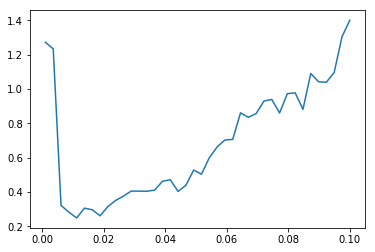

In [44]:
lrfinder(1e-3, 0.1, rnn, trainset_loader)

Training

In [45]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()

criterion = nn.CrossEntropyLoss().cuda()

criterion_val = nn.CrossEntropyLoss(size_average=False).cuda()

# learning_rate = 0.005
learning_rate = 0.0001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [46]:
clip = 1.0
epochs_number = 120
sample_history = []
best_val_loss = float("inf")

In [47]:
loss_list = []
val_list =[]
for epoch_number in range(epochs_number):
    epoch_loss = []
    for batch in trainset_loader:
        
        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )
        
        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )
        
        optimizer.zero_grad()

        logits, _ = rnn(input_sequences_batch_var, sequences_lengths)
        
        loss = criterion(logits, output_sequences_batch_var)
        loss_list.append(loss.data[0])
        epoch_loss.append(loss.data[0])
        loss.backward()
        
        torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

        optimizer.step()
    
    current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
    print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)
    
    current_val_loss = validate()
    print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
    print('')
    
    val_list.append(current_val_loss)
    
    if current_val_loss < best_val_loss:
        
        torch.save(rnn.state_dict(), 'music_rnn.pth')
        best_val_loss = current_val_loss

Training Loss: Epoch: 0 : 0.6486297845840454
Validation Loss: Epoch: 0 : 0.18648934628355707

Training Loss: Epoch: 1 : 0.17766371369361877
Validation Loss: Epoch: 1 : 0.16665818171657484

Training Loss: Epoch: 2 : 0.16188755258917809
Validation Loss: Epoch: 2 : 0.16094998097852498

Training Loss: Epoch: 3 : 0.16074519604444504
Validation Loss: Epoch: 3 : 0.15213753034468555

Training Loss: Epoch: 4 : 0.15469951555132866
Validation Loss: Epoch: 4 : 0.15134260837702795

Training Loss: Epoch: 5 : 0.1528901681303978
Validation Loss: Epoch: 5 : 0.14864290494642962

Training Loss: Epoch: 6 : 0.14913416653871536
Validation Loss: Epoch: 6 : 0.147850978531135

Training Loss: Epoch: 7 : 0.15001444891095161
Validation Loss: Epoch: 7 : 0.14738433791526515

Training Loss: Epoch: 8 : 0.14871039986610413
Validation Loss: Epoch: 8 : 0.14633489456415022

Training Loss: Epoch: 9 : 0.14909909665584564
Validation Loss: Epoch: 9 : 0.14780803625408886

Training Loss: Epoch: 10 : 0.1480446308851242
Validati

Process Process-192:
Process Process-189:
Process Process-191:
Process Process-190:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", l

KeyboardInterrupt: 

KeyboardInterrupt
KeyboardInterrupt


In [48]:
best_val_loss

0.14527413116642193

In [49]:
! ls

Baseline_LSTM_Piano.ipynb      data  music_rnn.pth  sample.mid
Baseline_Sequence_Model.ipynb  midi  README.md	    sample.midi


In [71]:
rnn.load_state_dict(torch.load('music_rnn.pth'))

### Validation

In [73]:
def sample_from_piano_rnn(sample_length=4, temperature=1, starting_sequence=None):

    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())

    
    else:
        current_sequence_input = Variable(starting_sequence)
    final_output_sequence = [current_sequence_input.data.squeeze(1)]
    
    hidden = None    

    for i in range(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

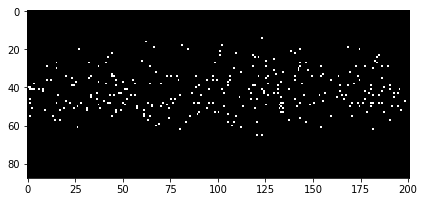

In [51]:
sample = sample_from_piano_rnn(sample_length=200, temperature=0.7).transpose()
io.imshow(sample)

In [31]:
midiwrite('sample.mid', sample.transpose(), dt=0.3)

In [33]:
FileLink('sample.mid')

/home/ubuntu/music-generation/sample.mid

Testloader

In [94]:
testset = NotesGenerationDataset('data/MuseData/test/', longest_sequence_length=None)

testset_loader = torch.utils.data.DataLoader(testset, batch_size=1, 
                                            shuffle=True, num_workers=4, drop_last=False)

In [95]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()

input_sequences_batch_var = input_sequences_batch.cuda()

In [96]:
sample_orig = batch[0].numpy()

In [97]:
sample_orig.shape

(1, 3402, 88)

In [98]:
sample_orig = sample_orig.reshape((3402, 88))

In [99]:
midiwrite('test0_orig.mid', sample_orig, dt=0.3)

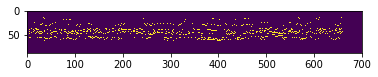

In [103]:
plt.imshow(sample_orig.transpose()[:,:700])

In [104]:
FileLink('test0_orig.mid')

/home/ubuntu/music-generation/test0_orig.mid

In [105]:
input_sequences_batch_var


( 0 ,.,.) = 
   0   0   0  ...    0   0   0

( 1 ,.,.) = 
   0   0   0  ...    0   0   0

( 2 ,.,.) = 
   0   0   0  ...    0   0   0
... 

(658,.,.) = 
   0   0   0  ...    0   0   0

(659,.,.) = 
   0   0   0  ...    0   0   0

(660,.,.) = 
   0   0   0  ...    0   0   0
[torch.cuda.FloatTensor of size 661x1x88 (GPU 0)]

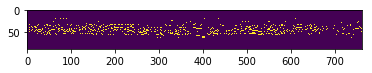

In [106]:
sample = sample_from_piano_rnn(sample_length=100, temperature=0.7, 
                               starting_sequence=input_sequences_batch_var).transpose()
plt.imshow(sample)

In [107]:
sample.shape


(88, 761)

In [108]:
midiwrite('test0.mid', sample.transpose(), dt=0.3)

In [109]:
FileLink('test0.mid')

/home/ubuntu/music-generation/test0.mid